[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hLyIyuIrQG5vKVOi-awG9f2aTHOapebv#scrollTo=e2mtTDvN2-oV)

# **Binary Classification on Tabular Data - Predicting Heart Disease**

This colab notebook shows how to set up and train a Neural network model for binary classification, when the dataset is tabular (rather than unstructured data like images or text) and has a mix of numeric and categorical features. Since tabular datasets are often made avaialble in CSV files, this colab notebook demonstrates the full CSV-to-trained-model workflow.

## **The Dataset**
The dataset has information on 303 patients, one in each row. Each column (i.e., feature) contains information on a particular attribute of the patient. The column named "Target" indicates if the patient has been diagnosed with heart disease or not and is the label (i.e., the dependent variable) that we want to predict using the other columns.

| Feature  | Description | Feature Type | Example Values |
|:-----|:-----|:------:|:------|
| **age** | Age in years | Numerical | 29, 45, 60 |
| **sex** | 1 = male; 0 = female | Categorical | 0, 1  |
| **cp**  | Chest pain type | Categorical | 0, 1, 2, 3 |
| **trestbps** | Resting blood pressure (in mm Hg on admission to the hospital)  | Numerical | 120, 140, 150 |
| **chol** | Serum cholesterol in mg/dl |  Numerical | 180, 220, 250 |
| **fbs** | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false) | Categorical | 0, 1 |
| **restecg** | Resting electrocardiographic results | Categorical | 0, 1, 2  |
| **thalach** | Maximum heart rate achieved | Numerical | 160, 180, 190 |
| **exang**  | Exercise induced angina (1 = yes; 0 = no) | Categorical | 0, 1 |
| **oldpeak**  | ST depression induced by exercise relative to rest | Numerical | 0.5, 1.0, 2.0  |
| **slope** | The slope of the peak exercise ST segment | Numerical | 0: Upsloping, 1: Flatsloping, 2: Downsloping |
| **ca** | Number of major vessels (0-3) colored by fluoroscopy | Both Numerical and Categorical | 0, 1, 2, 3 |
| **thal** | Thalium stress result  | Categorical | 1: Normal, 3: Normal, 6: Fixed defect, 7: Reversible defect |
| **target** | Have disease or not (1 = yes; 0 = no) | Target | 0, 1 |

**Note**:
- **cp**: Typical angina (chest pain), 1: Atypical angina (chest pain not related to heart), 2: Non-anginal pain (typically esophageal spasms (non heart related), 3: Asymptomatic (chest pain not showing signs of disease).
- **restecg**: 0: Nothing to note, 1: ST-T Wave abnormality, 2: Left ventricular hypertrophy.
-  **oldpeak**: ST depression (heart potentially not getting enough oxygen) induced by exercise relative to rest.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

When we train Deep learning models, randomness enters the process in a few different places.
- Starting values for weights and biases (the optimizer will try to improve these parameters).
- The order in which we process the minibatches (batches) when we do Stochastic  Gradient Descent (SGD).
- Wehn we split the data intto Train, Validation and Test etc.
- Dropout (if we use Regularization).

We next set the seed for the different random number generators so that the results will be the same everytime the notebook is run.

In [2]:
keras.utils.set_random_seed(42)

## **Read in the data**

In [3]:
df = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/heart.csv")
print(df.shape)

(303, 14)


The dataset has 303 rows and 14 columns (13 independent variables + 1 dependent variable). Let's take a quick look at the first few rows.

In [4]:
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0  


Let's take a quick look to see if the 1s and 0s are balanced.

In [5]:
#print(df.target.value_counts(normalize=False, dropna=False))
print(df.target.value_counts(normalize=True, dropna=False))

target
0    0.726073
1    0.273927
Name: proportion, dtype: float64


It's a bit imbalanced.

What's a 'naive' **baseline model** for this problem?
- The baseline model would be to just predict a probability of 0.0 for every patient. That will result in 72.6% accuracy.

Any fancy model we build needs to do better than this.

This dataset has both categorical variables and numeric variables.
It will be convenient ((for later processing) to collect these group of variables into two lists.

In [6]:
categorical_variables = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal']
numerics = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope']

Nueral Networks require all their inputs to be numeric so we will first preprocess this raw data as follow:
- *one-hot encode* the categorical variables
- *normalize* the numeric variables

With the `pandas.get_dummies` function, we can one-hot-encode the categorical variables.

In [7]:
df = pd.get_dummies(df, columns=categorical_variables)

In [8]:
print(df.head)

<bound method NDFrame.head of      age  trestbps  chol  thalach  oldpeak  slope  target  sex_0  sex_1  \
0     63       145   233      150      2.3      3       0  False   True   
1     67       160   286      108      1.5      2       1  False   True   
2     67       120   229      129      2.6      2       0  False   True   
3     37       130   250      187      3.5      3       0  False   True   
4     41       130   204      172      1.4      1       0   True  False   
..   ...       ...   ...      ...      ...    ...     ...    ...    ...   
298   52       118   186      190      0.0      2       0  False   True   
299   43       132   341      136      3.0      2       1   True  False   
300   65       135   254      127      2.8      2       1  False   True   
301   48       130   256      150      0.0      1       1  False   True   
302   63       150   407      154      4.0      2       1   True  False   

      cp_0  ...  exang_1   ca_0   ca_1   ca_2   ca_3  thal_1  thal_2 

Neural Networks work best when the inputs are all roughly in the same range. So, standard practice is to standardize the numeric variables.

Before we do so, let's split the data into an 80% training set and 30% test set (*why should we split* **before** *normalization?*)

To ensure that training of NN is not influenced by test set.

In [9]:
test_df = df.sample(frac=0.2, random_state=42)
train_df = df.drop(test_df.index)

In [10]:
print(train_df.shape)
print(test_df.shape)

(242, 30)
(61, 30)


Ok, let's calculate the mean and standard deviation of every numeric variable in the training set

In [11]:
means = train_df[numerics].mean()
sd = train_df[numerics].std()

In [12]:
print(means)
print(sd)

age          54.268595
trestbps    131.995868
chol        246.512397
thalach     149.805785
oldpeak       1.032645
slope         1.590909
dtype: float64
age          9.059861
trestbps    18.012789
chol        48.485377
thalach     23.132298
oldpeak      1.169729
slope        0.632783
dtype: float64


Let's standardize the train and test dataframes with these means and standard deviations.

In [13]:
train_df[numerics] = (train_df[numerics]-means)/sd
test_df[numerics] = (test_df[numerics]-means)/sd

In [14]:
print(train_df.head())

        age  trestbps      chol   thalach   oldpeak     slope  target  sex_0  \
0  0.963746  0.721939 -0.278690  0.008396  1.083461  2.226814       0  False   
1  1.405254  1.554681  0.814423 -1.807247  0.399542  0.646494       1  False   
2  1.405254 -0.665964 -0.361189 -0.899426  1.339930  0.646494       0  False   
3 -1.906055 -0.110803  0.071931  1.607891  2.109339  2.226814       0  False   
4 -1.464547 -0.110803 -0.876809  0.959447  0.314052 -0.933825       0   True   

   sex_1   cp_0  ...  exang_1   ca_0   ca_1   ca_2   ca_3  thal_1  thal_2  \
0   True  False  ...    False   True  False  False  False   False   False   
1   True  False  ...     True  False  False  False   True   False   False   
2   True  False  ...     True  False  False   True  False   False   False   
3   True  False  ...    False   True  False  False  False   False   False   
4  False  False  ...    False   True  False  False  False   False   False   

   thal_fixed  thal_normal  thal_reversible  
0        T

At this point, the data is entirely numeric.
The easiest way to feed data to Keras/Tensorflow is as Numpy arrays so we convert our two dataframes to Numpy arrays.

In [15]:
y_train = train_df["target"]
X_train = train_df.drop(columns=["target"])

y_test = test_df["target"]
X_test = test_df.drop(columns=["target"])

train_X = X_train.to_numpy(dtype=np.float32)
test_X  = X_test.to_numpy(dtype=np.float32)

train_y = y_train.to_numpy(dtype=np.float32)
test_y  = y_test.to_numpy(dtype=np.float32)

In [16]:
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(242, 29)
(61, 29)
(242,)
(61,)


## **Build a model**

### **Define model in Keras**

Creating an NN is usually just a few lines of Keras code.
- We will start with a single hidden layer.
- Since this is only a binary classification, we will use a sigmoid activation in the output layer.

In [17]:
num_columns = train_X.shape[1]

# define the input layer.
input = keras.Input(shape=(num_columns, ))

# feed the input vector to the hidden layer.
# optional: you can give names to each layer to help keep track. This does n't affect the training etc.
h = keras.layers.Dense(16, activation="relu", name="Hidden")(input)

# feed the output of the hidden layer to the output layer
output = keras.layers.Dense(1, activation="sigmoid", name="Output")(h)

# Tell keras that this (input, output) pair is your model
model =  keras.Model(input, output)

The `model.summary()` command is a good way to get a quick overview of what we have defined.

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden (Dense)                  │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

Let's hand-calculate the number of parameters to verify.

In [19]:
(29*16) + 16 + (16*1) + 1

497

We can "visualize" the network graphically as well using Keras' `plot_model` function.

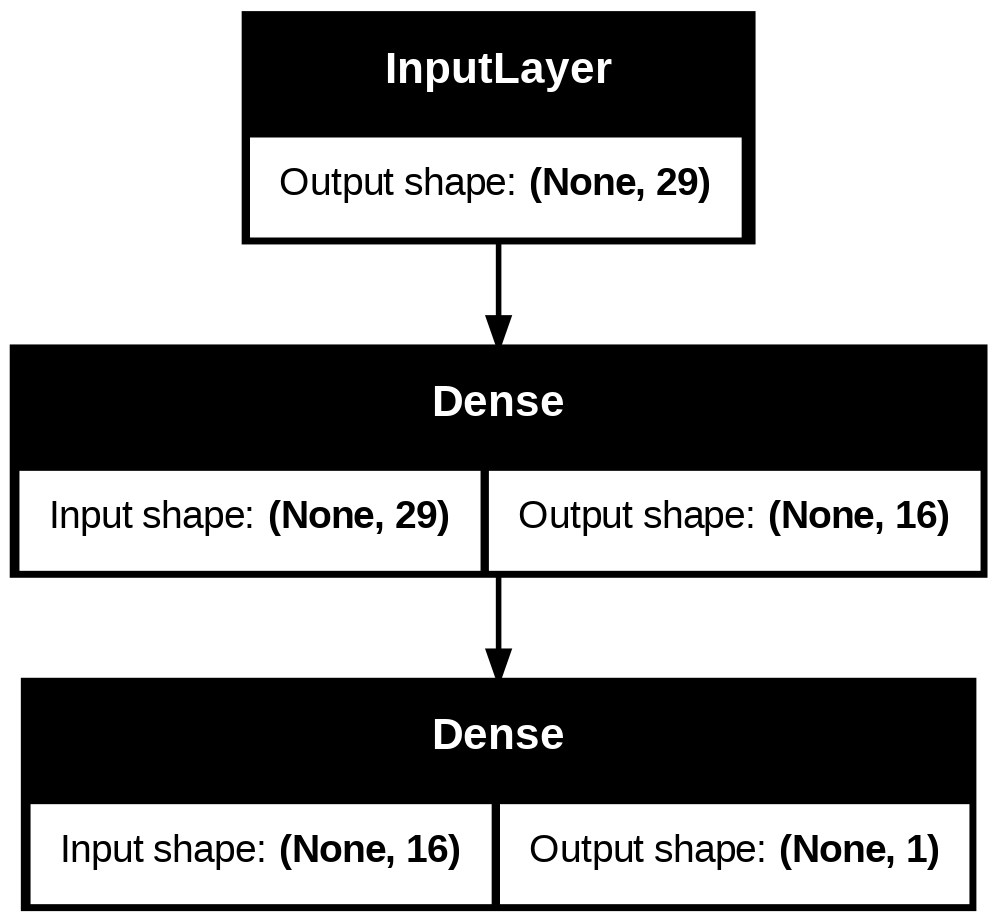

In [20]:
keras.utils.plot_model(model, show_shapes=True)

### **Set optimization parametters**:

Now that the model is defined, we need to tell Keras three things:
- What loss function to use - Since our output variable is binary, we will select the `binary_crossentropy` loss function.
- Which optimizer to use - we will use a sibling of SGD called **Adam** which is an excellent default choice.
- What metrics you want Keras to report out - in classification problems like this one, Accuracy is usually the metric you want to see.

In [21]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### **Train the model**

To kickoff training, we have to decide on three things:
- the *batch size*. 32 is a good number for the *batch size*.
- The number of epochs i.e. how many passes through the training data. Usually 20-30 epochs is a good starting point but since this dataset is very small, each epoch will very quick, so let's run it for 300 epochs, It will allow us to see if any overfitting happens.
- Whether we want to use a validation set. This will be useful for overfitting detection and regularization via early stopping so we will ask Keras to automatically use 20% of the data points as a validation set.

Ok, let's train the model using the `model.fit` function!
We will store the output of the training process in `history`. It will make it easy later to investigate what happened during training.

In [22]:
history = model.fit(train_X,
                    train_y,
                    epochs=300,             # number of epochs to run
                    batch_size=32,          # number of samples (i.e., data points) per batch
                    verbose=1,              # Verbosity during training
                    validation_split=0.2    # Use 20% of the training datat for validation
                    )

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.5511 - loss: 0.7246 - val_accuracy: 0.5918 - val_loss: 0.6891
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6019 - loss: 0.6898 - val_accuracy: 0.6122 - val_loss: 0.6697
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6082 - loss: 0.6660 - val_accuracy: 0.6122 - val_loss: 0.6530
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6477 - loss: 0.6450 - val_accuracy: 0.6122 - val_loss: 0.6372
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6715 - loss: 0.6256 - val_accuracy: 0.6531 - val_loss: 0.6225
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7010 - loss: 0.6072 - val_accuracy: 0.6939 - val_loss: 0.6088
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7350 - loss: 0.5902 - val_accuracy: 0.6939 - val_loss: 0.5959
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7517 - loss: 0.5743 - val_accuracy: 0.7143 - val_loss

Plotting metrics like loss and accuracy as a function of the number of epochs is a good way to understand how training has progressed.

In [23]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


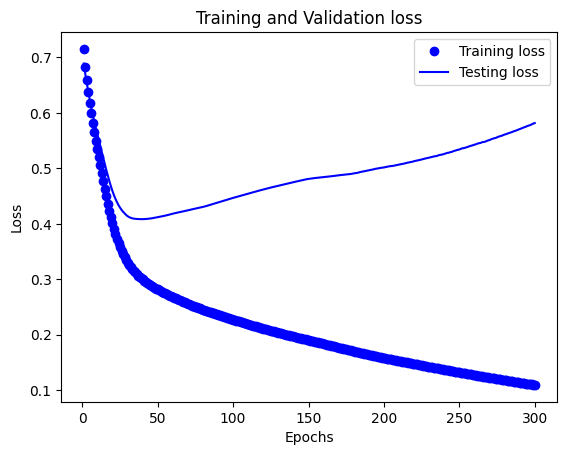

In [24]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values)+1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Testing loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

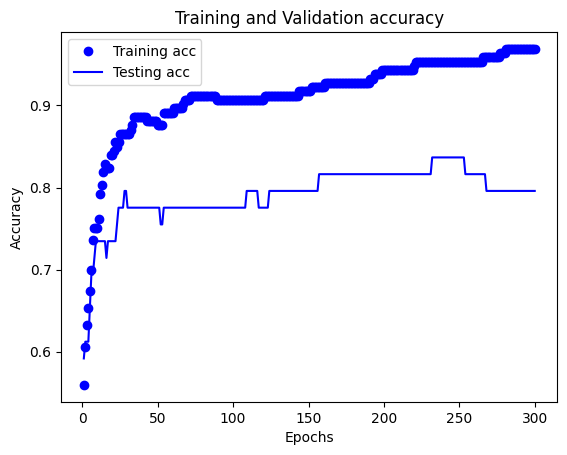

In [25]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Testing acc")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## ** Evaluate the model**

Let's see how well the model does on the test set.
`model.evaluate` is a very handly function to calculate the performance of your model on any dataset.

In [26]:
model.evaluate(test_X, test_y)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8490 - loss: 0.4713


[0.4810093939304352, 0.8360655903816223]